In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('/Users/avip/Downloads/house-prices-advanced-regression-techniques/train.csv')  

print(data.info())


numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

print(data.isnull().sum().max())  
encoder = OneHotEncoder(sparse=False, drop='first')  
encoded_features = encoder.fit_transform(data[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

data = data.drop(columns=categorical_cols)
data = pd.concat([data, encoded_features_df], axis=1)

X = data.drop('SalePrice', axis=1) 
y = data['SalePrice']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Data shapes: ", "Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

/Users/avip/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


/Users/avip/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


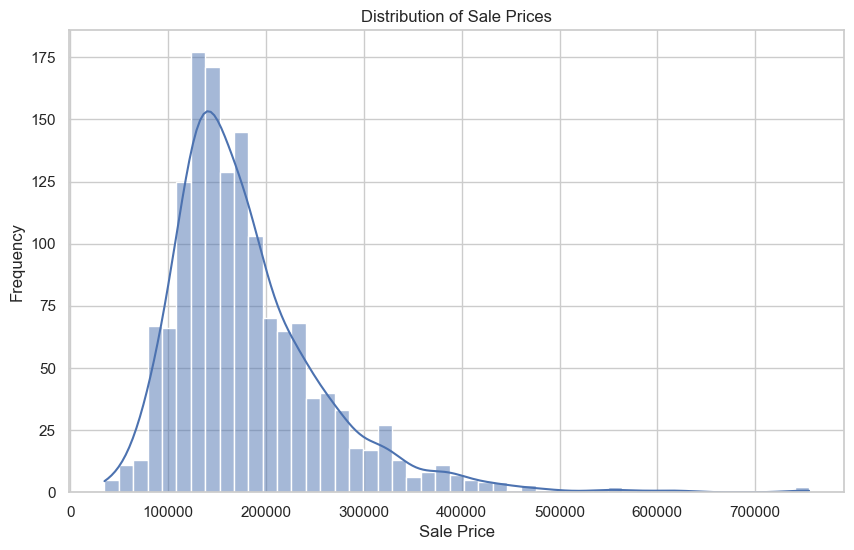

Skewness of Sale Prices: 1.8828757597682129


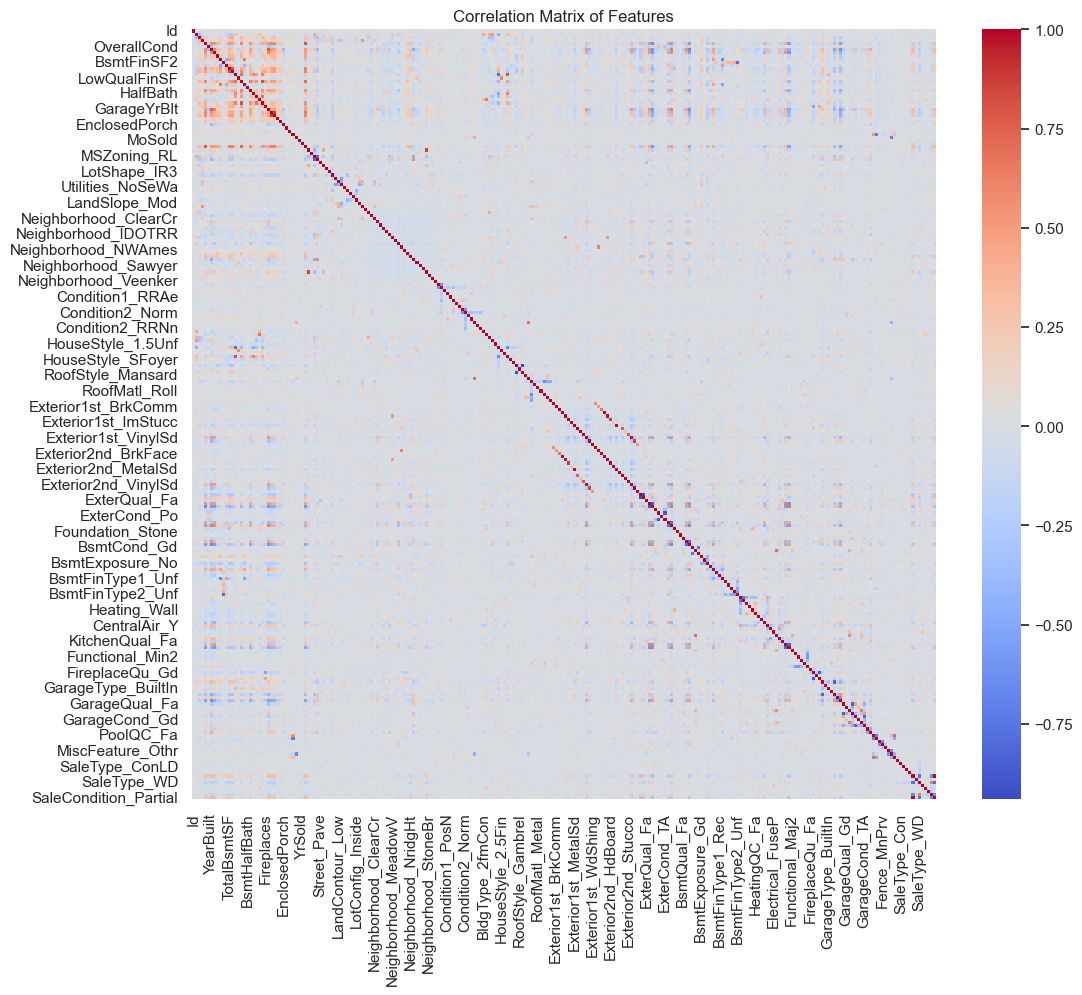

Top 10 correlations with SalePrice:
 SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


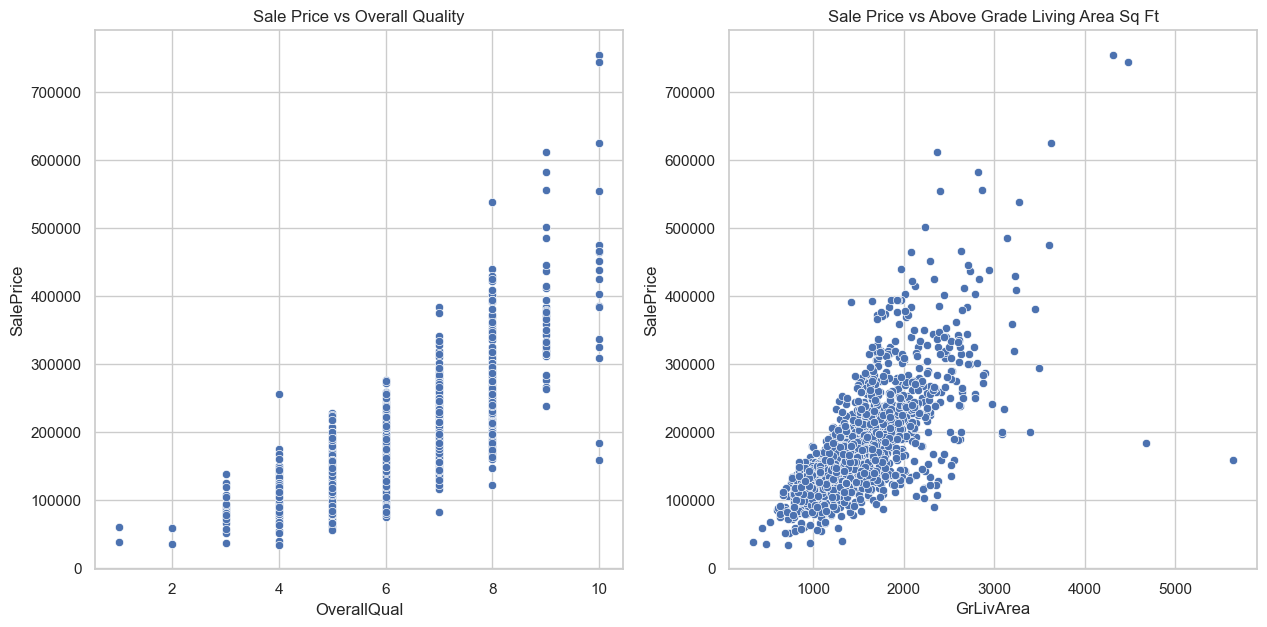

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

print("Skewness of Sale Prices:", data['SalePrice'].skew())

correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

print("Top 10 correlations with SalePrice:\n", correlation_matrix['SalePrice'].sort_values(ascending=False).head(11))


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=data['OverallQual'], y=data['SalePrice'])
plt.title('Sale Price vs Overall Quality')

plt.subplot(1, 2, 2)
sns.scatterplot(x=data['GrLivArea'], y=data['SalePrice'])
plt.title('Sale Price vs Above Grade Living Area Sq Ft')
plt.show()


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

def evaluate_model(model, X, y):
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(mse)
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    return mean_rmse, std_rmse

linear_rmse, linear_std = evaluate_model(linear_model, X_train, y_train)
rf_rmse, rf_std = evaluate_model(random_forest_model, X_train, y_train)
gbm_rmse, gbm_std = evaluate_model(gbm_model, X_train, y_train)

print(f"Linear Regression RMSE: {linear_rmse:.2f} ± {linear_std:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f} ± {rf_std:.2f}")
print(f"GBM RMSE: {gbm_rmse:.2f} ± {gbm_std:.2f}")


Linear Regression RMSE: 53879.32 ± 15309.31
Random Forest RMSE: 31437.68 ± 6063.00
GBM RMSE: 28991.53 ± 5723.30


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 4, 5],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best RMSE: 28226.29807601716


In [6]:
final_gbm_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
final_gbm_model.fit(X_combined, y_combined)

from sklearn.metrics import mean_squared_error

y_pred = final_gbm_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 19323.39


              Feature  Importance
4         OverallQual    0.525505
16          GrLivArea    0.133125
26         GarageCars    0.051538
12        TotalBsmtSF    0.044353
14           2ndFlrSF    0.041299
9          BsmtFinSF1    0.035482
13           1stFlrSF    0.022883
3             LotArea    0.021231
6           YearBuilt    0.013453
213  GarageFinish_Unf    0.010631


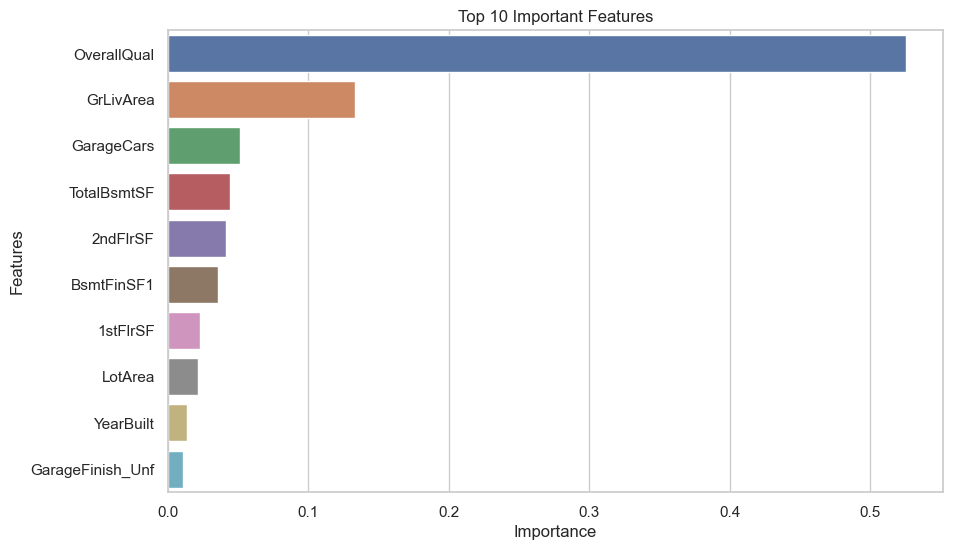

In [7]:
feature_importance = final_gbm_model.feature_importances_
features = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(features.head(10))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features.head(10))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


OverallQual     0.510870
GrLivArea       0.441338
GarageCars      0.357916
TotalBsmtSF     0.326573
GarageArea      0.321680
1stFlrSF        0.319072
YearBuilt       0.313787
MSSubClass      0.273967
YearRemodAdd    0.270453
GarageYrBlt     0.246047
Name: MI Scores, dtype: float64


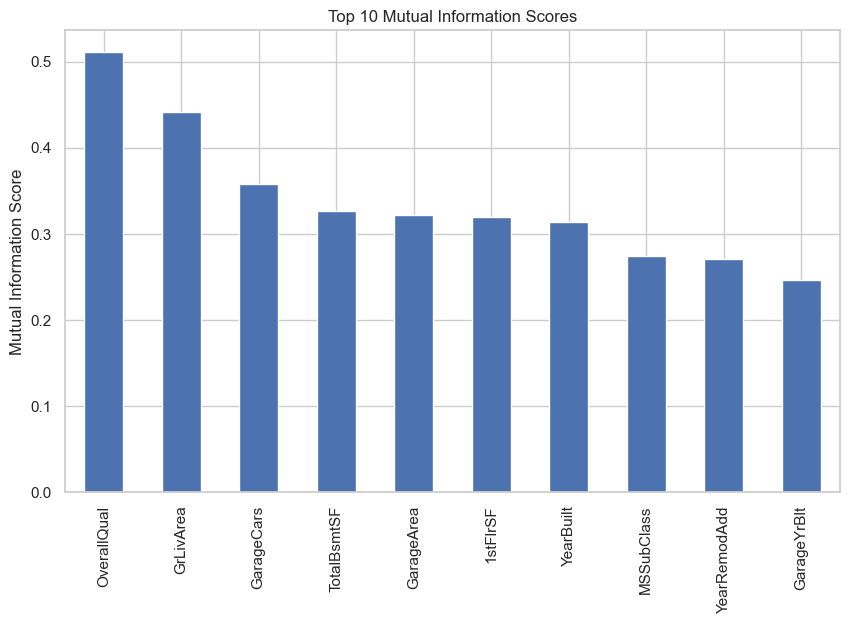

In [8]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores.head(10))

plt.figure(figsize=(10, 6))
mi_scores.head(10).plot(kind='bar')
plt.title('Top 10 Mutual Information Scores')
plt.ylabel('Mutual Information Score')
plt.show()
